In [ ]:
# Baseline 1: ARMA model, NVDA spot price
# Baseline 2: ARMA model, log scale, NVDA spot price

ARMA model for NVDA spot price:
Scrape using Beautiful Soup, display using Pandas

In [3]:
# Imports
# To import, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import os
import lxml
import pandas as pd
from bs4 import BeautifulSoup
from scipy import stats, signal
from scipy.optimize import minimize
import yfinance as yf
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

# Magic function to enable matplotlib charting in jupyter notebooks
%matplotlib inline

In [4]:
# Tickers
nvda = yf.Ticker("NVDA") 
qqq = yf.Ticker("QQQ")

In [49]:
data = nvda.history(period="5y", interval="1wk")
qqq_data = qqq.history(period="5y", interval="1wk")

In [53]:
print(data.head())

                               Open      High  ...  Dividends  Stock Splits
Date                                           ...                         
2020-02-24 00:00:00-05:00  6.524150  6.857503  ...      0.004           0.0
2020-03-02 00:00:00-05:00  6.897723  7.096758  ...      0.000           0.0
2020-03-09 00:00:00-04:00  5.976035  6.503640  ...      0.000           0.0
2020-03-16 00:00:00-04:00  5.291243  5.737390  ...      0.000           0.0
2020-03-23 00:00:00-04:00  5.124343  6.554457  ...      0.000           0.0

[5 rows x 7 columns]


In [51]:
#export
csvx = data[['Open', 'High', 'Low', 'Close']].to_csv("nvda_weekly_spot.csv", float_format="%.3f")
csvnq = qqq_data[['Open', 'High', 'Low', 'Close']].to_csv("qqq_weekly_spot.csv", float_format="%.3f")

In [52]:
print(data.describe())

             Open        High  ...   Dividends  Stock Splits
count  262.000000  262.000000  ...  262.000000    262.000000
mean    42.125947   44.504179  ...    0.000374      0.053435
std     41.121486   43.313976  ...    0.001432      0.664514
min      5.124343    5.737390  ...    0.000000      0.000000
25%     14.171155   14.829985  ...    0.000000      0.000000
50%     22.236909   23.060505  ...    0.000000      0.000000
75%     48.096403   49.811496  ...    0.000000      0.000000
max    148.669750  153.130005  ...    0.010000     10.000000

[8 rows x 7 columns]


In [42]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-02-24 00:00:00-05:00 to 2025-02-24 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          262 non-null    float64
 1   High          262 non-null    float64
 2   Low           262 non-null    float64
 3   Close         262 non-null    float64
 4   Volume        262 non-null    int64  
 5   Dividends     262 non-null    float64
 6   Stock Splits  262 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 16.4 KB


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [43]:
dfm = pd.read_csv("nvda_weekly_spot.csv")
print(dfm.head())

                        Date   Open   High    Low  Close
0  2020-02-24 00:00:00-05:00  6.524  6.858  6.020  6.724
1  2020-03-02 00:00:00-05:00  6.898  7.097  6.427  6.627
2  2020-03-09 00:00:00-04:00  5.976  6.504  5.376  5.999
3  2020-03-16 00:00:00-04:00  5.291  5.737  4.501  5.125
4  2020-03-23 00:00:00-04:00  5.124  6.554  4.945  6.296


In [4]:
# This class will download daily data from yahoo finance
class DailyFinancialData:
    
    # Class constructor to store parameters, download and format data
    def __init__(self, ticker, startDate, endDate):
        
        # Member Data
        self.ticker = ticker
        self.startDate = startDate
        self.endDate = endDate

        # Download and format data
        self.download_data()
        self.prepare_data()

    # Download data from yahoo finance
    def download_data(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        self.raw_data = yf.download(self.ticker, self.startDate, self.endDate)

    # Compute returns and drop NaN values
    def prepare_data(self):
        
        # Grab columns of interest
        copy_columns = ['Close']
        self.df = self.raw_data[copy_columns].copy()
        
        # Compute returns and drop NaN values
        self.df["Returns"] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        self.df.dropna(inplace=True)
    
    def plot_data(self, cols=None):
        if cols is None:
            cols = ['Close']
        self.df[cols].plot(title=self.ticker)
    
    def show_data(self):
        print("\n*** HEAD ***")
        print(self.df.head())

        print("\n*** TAIL ***")
        print(self.df.tail())

In [ ]:
# This class will download tick data from yahoo finance
class TickFinancialData:
    
    # Class constructor to store parameters, download and format data
    # Note that period will show the current price (delayed by around 15 mins)
    def __init__(self, ticker, period, interval, price_column):
        
        # Member Data
        self.ticker = ticker
        self.price_column = price_column
        
        # The period can be "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", or "ytd
        self.period = period 
        
        # The interval can be "1m", "2m", "5m", "10m", "30m", "1h", "1d", "1wk", "1mo" etc.
        self.interval = interval
        
        # Download and format data
        self.download_data()
        self.prepare_data()

    # Download data from yahoo finance
    def download_data(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        print(f"(15m Delayed Data)")
        
        instrument = yf.Ticker(self.ticker)
        self.raw_data = instrument.history(period=self.period, interval=self.interval)
        
        print(f"Last Time Index - {self.raw_data.index[-1]}")
        
    # Compute returns and drop NaN values
    def prepare_data(self):
        
        # Grab columns of interest
        self.data = self.raw_data[[self.price_column]].copy()
        
        # Compute returns and drop NaN values
        self.data["Returns"] = np.log(self.data[[self.price_column]] / self.data[[self.price_column]].shift(1))
        self.data.dropna(inplace=True)
        
    def plot_data(self, cols=None):
        if cols is None:
            cols = self.price_column
        self.data[cols].plot(title=self.ticker)
    
    def show_data(self):
        print("\n*** HEAD ***")
        print(self.data.head())

        print("\n*** TAIL ***")
        print(self.data.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



*** HEAD ***
Price           Close   Returns
Ticker           NVDA          
Date                           
2023-02-14  22.954304  0.052873
2023-02-15  22.747452 -0.009052
2023-02-16  21.986008 -0.034047
2023-02-17  21.372454 -0.028303
2023-02-21  20.639986 -0.034873

*** TAIL ***
Price            Close   Returns
Ticker            NVDA          
Date                            
2025-03-03  114.059998 -0.090949
2025-03-04  115.989998  0.016779
2025-03-05  117.300003  0.011231
2025-03-06  110.570000 -0.059086
2025-03-07  112.690002  0.018992


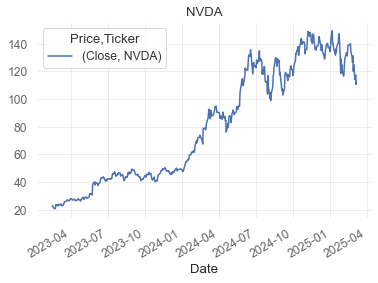

In [5]:
# Example 1: NVDA
# 1. Define ticker
ticker = "NVDA"

# 2. Define backtest period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load data
fd = DailyFinancialData(ticker, startDate, endDate)

# 4. Plot data
fd.show_data()
fd.plot_data()

In [6]:
# Tick data: NVDA
# Set Ticker, Data Period and Time Interval
# Note: All tick data is delayed by 15 minutes.
ticker = "NVDA"
period = "5d"    # The period can be "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", or "ytd
interval = "30m"  # The interval can be "1m", "2m", "5m", "10m", "30m", "1h", "1d", "1wk", "1mo" etc.
price_column = "Close"
# Download and Format Financial Data
fd = TickFinancialData(ticker, period, interval, price_column)

# Show Data
fd.show_data()
fd.plot_data()

[*********************100%***********************]  1 of 1 completed

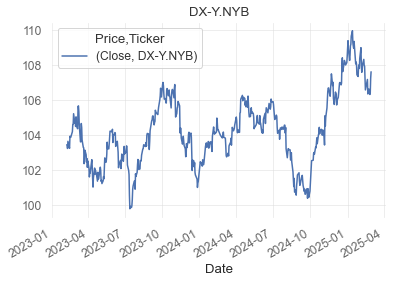

In [8]:
# Example 2: DXY
# 1. Define ticker
ticker = "DX-Y.NYB"

# 2. Define backtest period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load data
fd = DailyFinancialData(ticker, startDate, endDate)

# 4. Plot data
fd.plot_data()

In [11]:
def base_ar(price, time):
    
    X = np.zeros((len(price) - time, time + 1))
    y = price[time:].values
    
    
    X[:, 0] = 1  
    for i in range(len(price) - time):
        X[i, 1:] = price[i:i+time].values
    
    #Ordinary Least Squares fitting
    coefficients = np.linalg.lstsq(X, y, rcond=None)[0]
    fitted = np.dot(X, coefficients)
    residuals = y - fitted
    
    print(f"AR({time}) Coefficients:")
    print(f"Intercept: {coefficients[0]:.4f}")
    for i in range(1, len(coefficients)):
        print(f"Weeks: {i}: {coefficients[i]:.4f}")
    
    return coefficients, residuals

In [17]:
def base_ar_predict(prices, coefficients, residuals, k=3):
    
    residual_std = np.std(residuals)
    z = 1.96  #95% CI

    lags = len(coefficients) - 1
    recent_prices = prices[-lags:].values

    predictions = []
    lower_bounds = []
    upper_bounds = []
    
    for i in range(k):

        next_price = coefficients[0] 
        for j in range(lags):
            if i + j < lags:
                next_price += coefficients[j+1] * recent_prices[-(lags-j)]
            else:
                next_price += coefficients[j+1] * predictions[i+j-lags]
        
        prediction_error = z * residual_std
        lower_bound = next_price - prediction_error
        upper_bound = next_price + prediction_error
        
        predictions.append(next_price)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
    
    last_date = prices.index[-1]
    pred_dates = pd.date_range(start=last_date + pd.Timedelta(days=0), 
                               periods=k, 
                               freq='W-FRI')
    
    
    results = pd.DataFrame({
        'Prediction': predictions,
        'Lower_Bound': lower_bounds,
        'Upper_Bound': upper_bounds
    }, index=pred_dates)
    
    return results

In [20]:
nvda = yf.Ticker("NVDA")
data = nvda.history(period="5y", interval="1wk")
close_prices = data['Close']
c, r = base_ar(close_prices, 20)
price_pred = base_ar_predict(close_prices, c, r, 4)
print("\nAutoregressive NVDA Price Prediction:")
print(price_pred)

AR(20) Coefficients:
Intercept: 0.5251
Weeks: 1: -0.2169
Weeks: 2: 0.0349
Weeks: 3: 0.2984
Weeks: 4: -0.3227
Weeks: 5: 0.2142
Weeks: 6: -0.0801
Weeks: 7: -0.0192
Weeks: 8: 0.0935
Weeks: 9: -0.1705
Weeks: 10: 0.1380
Weeks: 11: 0.0526
Weeks: 12: 0.1302
Weeks: 13: -0.1275
Weeks: 14: -0.1673
Weeks: 15: 0.1977
Weeks: 16: -0.2161
Weeks: 17: 0.1867
Weeks: 18: 0.0455
Weeks: 19: -0.0318
Weeks: 20: 0.9495

Autoregressive NVDA Price Prediction:
                           Prediction  Lower_Bound  Upper_Bound
2025-03-07 00:00:00-05:00  116.878061   109.378519   124.377602
2025-03-14 00:00:00-04:00  116.477424   108.977883   123.976965
2025-03-21 00:00:00-04:00  116.352427   108.852886   123.851968
2025-03-28 00:00:00-04:00  115.447113   107.947572   122.946654
